In [38]:
import pandas as pd
import numpy as np
import plotly.express as px
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import Birch
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.metrics import accuracy_score

In [39]:
user_data = pd.read_csv("../data/customers.csv").dropna()
actions_data = pd.read_csv("../data/dataset.csv").dropna().astype(int)
cars_data = pd.read_csv("../data/cars_about.csv").dropna()

## Preprocess user data

In [40]:
user_data

,customer_id,gender,married,age,graduated,profession,familySize
0,45,Male,No,22,No,Healthcare,4.0
1,817,Female,Yes,38,Yes,Engineer,3.0
2,495,Female,Yes,67,Yes,Engineer,1.0
3,36,Male,Yes,67,Yes,Lawyer,2.0
4,76,Female,Yes,40,Yes,Entertainment,6.0
...,...,...,...,...,...,...,...
315,353,Male,Yes,74,Yes,Lawyer,2.0
316,411,Female,No,30,No,Homemaker,4.0
317,297,Female,No,37,Yes,Artist,2.0
318,186,Female,No,22,No,Marketing,1.0


In [41]:
# Identify the categorical columns
cat_cols = ['gender', 'married', 'graduated', 'profession']

# Convert the categorical columns to numerical using Label Encoding
for col in cat_cols:
    le = LabelEncoder()
    user_data[col] = le.fit_transform(user_data[col])

user_data

,customer_id,gender,married,age,graduated,profession,familySize
0,45,1,0,22,0,5,4.0
1,817,0,1,38,1,2,3.0
2,495,0,1,67,1,2,1.0
3,36,1,1,67,1,7,2.0
4,76,0,1,40,1,3,6.0
...,...,...,...,...,...,...,...
315,353,1,1,74,1,7,2.0
316,411,0,0,30,0,6,4.0
317,297,0,0,37,1,0,2.0
318,186,0,0,22,0,8,1.0


## Preprocess cars data

In [42]:
cars_data = pd.read_csv("../data/cars_about.csv").dropna()

cars_data["brand"] = cars_data.car_model.apply(lambda a: a.split()[0])
cars_data = cars_data.drop(columns=["car_model", "engine", "car_id"])
cars_data["price"] = cars_data['price'].apply(lambda a: int(a[1:]))

cars_data['used_label'] = cars_data["used_label"].apply(lambda a: 1 if a=="Used" else 0)
# Identify the categorical columns
car_cat_cols = ['exteriorColor', 'interiorColor', 'drivetrain', 'fuelType', 'transmission', 'brand']

# Convert the categorical columns to numerical using Label Encoding
for col in car_cat_cols:
    le = LabelEncoder()
    cars_data[col] = le.fit_transform(cars_data[col])

cars_data

,used_label,price,exteriorColor,interiorColor,drivetrain,minMPG,maxMPG,fuelType,transmission,mileage,brand
0,1,39,139,11,4,19.0,27.0,3,20,29403.0,28
1,1,49,145,11,3,19.0,24.0,3,2,32929.0,10
2,1,41,62,11,3,15.0,21.0,3,20,23173.0,25
3,1,28,66,83,4,29.0,35.0,3,28,10598.0,13
4,1,49,53,10,4,20.0,27.0,3,20,28137.0,19
...,...,...,...,...,...,...,...,...,...,...,...
399,1,33,46,11,3,18.0,25.0,3,20,43807.0,16
400,0,30,163,57,2,34.0,30.0,5,28,41944.0,28
401,1,35,11,11,2,22.0,29.0,3,24,49386.0,5
402,1,35,168,49,3,16.0,22.0,3,9,115795.0,6


## Preprocess actions data

In [43]:
actions_data = actions_data.rename(columns = {"item_id":"car_id"})

In [44]:
actions_pivot_table = pd.pivot_table(actions_data.sort_values(by="car_id"), values='interaction', index='user_id', columns='car_id').fillna(0)

In [45]:
actions_data.car_id.nunique()

109

In [46]:
px.imshow(actions_pivot_table)

In [47]:
actions_data = pd.melt(actions_pivot_table.reset_index(), id_vars='user_id', value_vars=actions_pivot_table.columns).rename(columns={"value":"interaction"})

In [48]:
actions_data.interaction.unique()

array([1, 0])

In [49]:
actions_data

,user_id,car_id,interaction
0,0,0,1
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
8170,70,402,0
8171,71,402,0
8172,72,402,0
8173,73,402,0


In [50]:
actions_data.interaction = actions_data.interaction.apply(lambda a: 1 if a > 0.5 else 0)

In [51]:
actions_data

,user_id,car_id,interaction
0,0,0,1
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
8170,70,402,0
8171,71,402,0
8172,72,402,0
8173,73,402,0


## CatBoost inputs

1. собираю фичи топ n понравившихся авто
2. конкатенирую фичи понравившихся авто с таргет авто
3. делаю бинарную классификацию 

In [54]:
N_POSITIVE = 5

In [55]:
cars_data

,used_label,price,exteriorColor,interiorColor,drivetrain,minMPG,maxMPG,fuelType,transmission,mileage,brand
0,1,39,139,11,4,19.0,27.0,3,20,29403.0,28
1,1,49,145,11,3,19.0,24.0,3,2,32929.0,10
2,1,41,62,11,3,15.0,21.0,3,20,23173.0,25
3,1,28,66,83,4,29.0,35.0,3,28,10598.0,13
4,1,49,53,10,4,20.0,27.0,3,20,28137.0,19
...,...,...,...,...,...,...,...,...,...,...,...
399,1,33,46,11,3,18.0,25.0,3,20,43807.0,16
400,0,30,163,57,2,34.0,30.0,5,28,41944.0,28
401,1,35,11,11,2,22.0,29.0,3,24,49386.0,5
402,1,35,168,49,3,16.0,22.0,3,9,115795.0,6


In [56]:
column_names = []
cat_columns = ['used_label', 'exteriorColor', 'interiorColor', 'drivetrain', 'fuelType', 'transmission', 'brand']
cat_features = []

for index in range(N_POSITIVE):
    for column in cars_data.columns:
        column_names.append(f"car_{index}_{column}")
        
for column in cars_data.columns:
    column_names.append(f"target_{column}")

for column in column_names:
    for c_column in cat_columns:
        if c_column in column:
            cat_features.append(column)
        
dataset = pd.DataFrame(columns=column_names + ["interaction"])

for user_id in actions_data.user_id.unique():
    for target_car_id in actions_data.car_id.unique():
        # len(cars_data.columns) * (N_POSITIVE + 1))
        matrix_features = []
        features = []
        current_positive_samples = actions_data.query(f"user_id == {user_id}").query(f"car_id != {target_car_id}").query("interaction == 1")
        # print()
        if len(current_positive_samples) < N_POSITIVE: continue

        for car_id in current_positive_samples.sample(N_POSITIVE).car_id.to_list():
            matrix_features.append(cars_data.iloc[car_id].to_list())
        matrix_features.append(cars_data.iloc[target_car_id].to_list())
        matrix_features.append(int(actions_data.loc[actions_data.car_id == target_car_id].query(f"user_id == {user_id}").interaction))
        
        for item in matrix_features:
            if isinstance(item, list):
                for elem in item:
                    features.append(elem)
            else:
                features.append(item)
        # print(features)
        dataset = pd.concat([dataset, pd.DataFrame.from_records([dict(zip(dataset.columns, features))])])

# dataset = dataset.astype(int)

In [57]:
dataset

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand,interaction
0,1.0,23.0,173.0,8.0,2.0,18.0,27.0,3.0,9.0,99697.0,...,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,28.0,1
0,1.0,28.0,174.0,27.0,3.0,16.0,22.0,3.0,9.0,139597.0,...,62.0,11.0,3.0,15.0,21.0,3.0,20.0,23173.0,25.0,0
0,1.0,23.0,173.0,8.0,2.0,18.0,27.0,3.0,9.0,99697.0,...,66.0,83.0,4.0,29.0,35.0,3.0,28.0,10598.0,13.0,0
0,1.0,39.0,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,...,53.0,10.0,4.0,20.0,27.0,3.0,20.0,28137.0,19.0,0
0,1.0,39.0,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,...,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,28.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,44.0,131.0,8.0,2.0,19.0,26.0,3.0,24.0,14445.0,...,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,17.0,1
0,1.0,51.0,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,...,11.0,11.0,2.0,21.0,28.0,3.0,24.0,10769.0,22.0,0
0,1.0,18.0,85.0,68.0,5.0,21.0,30.0,3.0,15.0,58157.0,...,56.0,35.0,2.0,19.0,26.0,3.0,20.0,22492.0,10.0,0
0,1.0,51.0,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,...,90.0,25.0,4.0,26.0,33.0,3.0,28.0,23320.0,23.0,0


In [58]:
dataset.shape

(6931, 67)

In [59]:
dataset.interaction.value_counts()

0    6438
1     493
Name: interaction, dtype: int64

In [60]:
dataset

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand,interaction
0,1.0,23.0,173.0,8.0,2.0,18.0,27.0,3.0,9.0,99697.0,...,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,28.0,1
0,1.0,28.0,174.0,27.0,3.0,16.0,22.0,3.0,9.0,139597.0,...,62.0,11.0,3.0,15.0,21.0,3.0,20.0,23173.0,25.0,0
0,1.0,23.0,173.0,8.0,2.0,18.0,27.0,3.0,9.0,99697.0,...,66.0,83.0,4.0,29.0,35.0,3.0,28.0,10598.0,13.0,0
0,1.0,39.0,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,...,53.0,10.0,4.0,20.0,27.0,3.0,20.0,28137.0,19.0,0
0,1.0,39.0,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,...,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,28.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,44.0,131.0,8.0,2.0,19.0,26.0,3.0,24.0,14445.0,...,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,17.0,1
0,1.0,51.0,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,...,11.0,11.0,2.0,21.0,28.0,3.0,24.0,10769.0,22.0,0
0,1.0,18.0,85.0,68.0,5.0,21.0,30.0,3.0,15.0,58157.0,...,56.0,35.0,2.0,19.0,26.0,3.0,20.0,22492.0,10.0,0
0,1.0,51.0,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,...,90.0,25.0,4.0,26.0,33.0,3.0,28.0,23320.0,23.0,0


In [61]:
px.bar(dataset.interaction.value_counts())

In [77]:
balanced_dataset = pd.concat([dataset.loc[dataset.interaction == 1], dataset.loc[dataset.interaction == 0].sample(int(dataset.interaction.value_counts()[1] * 4))])

In [78]:
px.bar(balanced_dataset.interaction.value_counts())

In [64]:
# balanced_dataset = dataset

In [79]:
from sklearn.model_selection import train_test_split
# Split into training and validation sets
train_df, val_df = train_test_split(balanced_dataset.astype(int), test_size=0.2, random_state=42)
X_train, y_train = train_df.drop(columns=['interaction']), train_df[["interaction"]]

# Split into validation and test sets
val_df, test_df = train_test_split(val_df, test_size=0.2, random_state=42)

X_val, y_val = val_df.drop(columns=['interaction']), val_df[["interaction"]]
X_test, y_test = test_df.drop(columns=['interaction']), test_df[["interaction"]]

In [80]:
X_train.shape, X_val.shape, X_test.shape

((1972, 66), (394, 66), (99, 66))

In [81]:
X_train

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_price,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand
0,1,107,11,11,3,14,19,3,2,28000,...,28,66,11,4,22,29,3,9,21055,17
0,1,28,66,11,4,22,29,3,9,21055,...,46,99,63,3,17,20,3,6,16854,28
0,1,18,157,83,1,18,24,3,9,124282,...,33,111,65,2,22,27,3,16,43496,2
0,1,31,88,37,3,16,22,3,9,47661,...,25,180,83,5,15,22,0,9,135228,10
0,0,39,64,52,2,21,28,3,24,44271,...,17,138,8,4,30,40,3,28,21368,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,71,122,82,2,131,117,1,1,15002,...,63,173,11,2,18,23,3,16,38729,24
0,1,18,139,11,3,14,19,0,9,110111,...,72,173,83,5,18,25,3,32,6626,3
0,1,20,158,83,5,20,29,3,15,102893,...,19,11,60,3,0,0,0,26,141281,10
0,1,122,173,81,2,80,77,2,0,29918,...,39,64,52,2,21,28,3,24,44271,22


In [82]:
# Create CatBoost model
model = CatBoostClassifier(iterations=5000, 
                           learning_rate=0.05, 
                           eval_metric='AUC',
                           custom_metric=['Accuracy', 'Precision', 'Recall', 'F1', 'TotalF1'],
                           loss_function='CrossEntropy', 
                           cat_features=cat_features, 
                           random_seed=42)

# Fit the model on the training data
model.fit(X_train, y_train, 
          eval_set=(X_val, y_val), 
          early_stopping_rounds=50,
          verbose=10)

# Make predictions on the test data
y_pred = model.predict(X_train)

/home/proton/anaconda3/envs/proton/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



0:	test: 0.5811222	best: 0.5811222 (0)	total: 4.25ms	remaining: 21.2s
10:	test: 0.7630437	best: 0.7630437 (10)	total: 39.7ms	remaining: 18s
20:	test: 0.7761279	best: 0.7761279 (20)	total: 76.1ms	remaining: 18.1s
30:	test: 0.7839987	best: 0.7839987 (30)	total: 110ms	remaining: 17.6s
40:	test: 0.7742616	best: 0.7839987 (30)	total: 147ms	remaining: 17.7s
50:	test: 0.7732879	best: 0.7839987 (30)	total: 188ms	remaining: 18.2s
60:	test: 0.7758845	best: 0.7839987 (30)	total: 233ms	remaining: 18.9s
70:	test: 0.7805501	best: 0.7839987 (30)	total: 275ms	remaining: 19.1s
80:	test: 0.7786433	best: 0.7839987 (30)	total: 314ms	remaining: 19.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7839987017
bestIteration = 30

Shrink model to first 31 iterations.


In [83]:
model.save_model("catboost_info/catboost",
           format="cbm",
           export_parameters=None,
           pool=None)

In [84]:
submission_table = pd.DataFrame(dict(gt = y_train.interaction, pred = y_pred))

In [85]:
n_correct = 0
for i in range(len(submission_table)):
    current_row = list(submission_table.iloc[i])
    if current_row[0] == current_row[1]:
        n_correct += 1
print(f"test accurracy: {n_correct/len(y_pred)}")

test accurracy: 0.8012170385395537


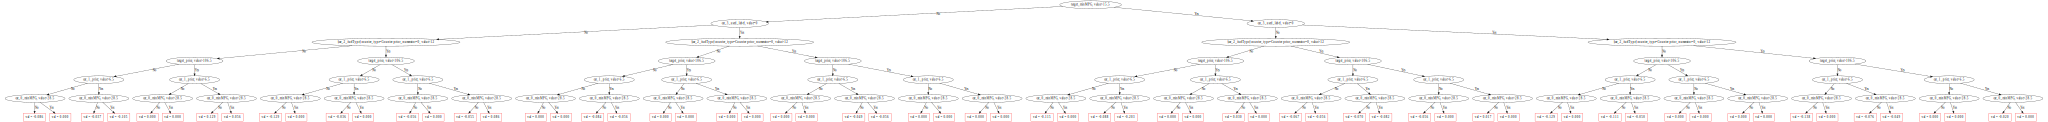

In [86]:
pool = Pool(X_test, y_test, cat_features=cat_features, feature_names=list(X_test.columns))
model.plot_tree(
    tree_idx=0,
    pool=pool
)


In [87]:
from sklearn import metrics
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

# The histogram of scores compared to true labels
fig_hist = px.histogram(
    x=y_pred_proba, color=y_test.interaction.to_list(), nbins=50,
    labels=dict(color='True Labels', x='Score')
)

fig_hist.show()


# Evaluating model performance at various thresholds
df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='TPR and FPR at every threshold',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

/home/proton/anaconda3/envs/proton/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [88]:
from sklearn.metrics import auc
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f}) ::: CatBoost',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [89]:
X_test

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_price,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand
0,1,44,131,8,2,19,26,3,24,14445,...,33,139,83,3,16,22,3,26,81375,10
0,1,9,19,11,2,18,22,3,3,77792,...,35,15,43,4,24,31,3,28,19527,15
0,1,20,158,83,5,20,29,3,15,102893,...,30,142,37,4,17,24,3,9,28357,10
0,1,44,131,8,2,19,26,3,24,14445,...,28,174,27,3,16,22,3,9,139597,6
0,1,28,66,83,4,29,35,3,28,10598,...,39,139,11,4,19,27,3,20,29403,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,44,131,8,2,19,26,3,24,14445,...,18,139,11,3,14,19,0,9,110111,10
0,1,18,139,11,3,14,19,0,9,110111,...,56,132,41,2,16,22,3,24,33427,22
0,1,43,56,35,2,19,26,3,20,22492,...,23,11,83,5,17,23,3,6,105469,28
0,0,30,74,11,5,19,30,3,20,33296,...,56,132,41,2,16,22,3,24,33427,22


In [90]:
y_test

,interaction
0,0
0,0
0,0
0,0
0,1
...,...
0,0
0,0
0,0
0,0


In [100]:
class CatPredictor:
    def __init__(self, catboost_path="../weights/catboost"):
        self.catboost = CatBoostClassifier().load_model(catboost_path)
        self.N_POSITIVE = 5

    def preprocess_car_data(self, path2data):
        cars_data = pd.read_csv("../data/cars_about.csv").dropna()

        cars_data["brand"] = cars_data.car_model.apply(lambda a: a.split()[0])
        cars_data = cars_data.drop(columns=["car_model", "engine", "car_id"])
        cars_data["price"] = cars_data['price'].apply(lambda a: int(a[1:]))

        cars_data['used_label'] = cars_data["used_label"].apply(lambda a: 1 if a=="Used" else 0)
        # Identify the categorical columns
        car_cat_cols = ['exteriorColor', 'interiorColor', 'drivetrain', 'fuelType', 'transmission', 'brand']

        # Convert the categorical columns to numerical using Label Encoding
        for col in car_cat_cols:
            le = LabelEncoder()
            cars_data[col] = le.fit_transform(cars_data[col])

        cars_data
    def preprocess_user_vector(self, actions_data):
        
        # matrix_features = []
        # features = []
        # current_positive_samples = actions_data.query(f"car_id != {target_car_id}").query("interaction == 1")
        # # print()
        # if len(current_positive_samples) < N_POSITIVE: AssertionError("need cold start")

        # for car_id in current_positive_samples.sample(N_POSITIVE).car_id.to_list():
        #     matrix_features.append(cars_data.iloc[car_id].to_list())
        # matrix_features.append(cars_data.iloc[target_car_id].to_list())
        # matrix_features.append(int(actions_data.loc[actions_data.car_id == target_car_id].query(f"user_id == {user_id}").interaction))
        
        # for item in matrix_features:
        #     if isinstance(item, list):
        #         for elem in item:
        #             features.append(elem)
        #     else:
        #         features.append(item)
        # # print(features)
        # dataset = pd.concat([dataset, pd.DataFrame.from_records([dict(zip(dataset.columns, features))])])
    
    def predict(self, user_vector:list):
        assert len(user_vector) == (self.N_POSITIVE + 1) * 6
        

catpred = CatPredictor()


In [103]:
actions_data.car_id.unique().tolist()

[0,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 15,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 28,
 33,
 35,
 40,
 45,
 50,
 59,
 62,
 64,
 69,
 74,
 75,
 78,
 82,
 85,
 89,
 91,
 97,
 98,
 99,
 102,
 115,
 120,
 123,
 130,
 132,
 135,
 143,
 146,
 147,
 151,
 153,
 170,
 179,
 187,
 201,
 202,
 211,
 212,
 220,
 221,
 230,
 232,
 245,
 246,
 247,
 249,
 255,
 259,
 263,
 266,
 272,
 273,
 280,
 284,
 285,
 293,
 307,
 308,
 309,
 312,
 317,
 318,
 319,
 327,
 329,
 333,
 336,
 338,
 341,
 347,
 352,
 355,
 358,
 363,
 364,
 365,
 366,
 370,
 373,
 376,
 380,
 382,
 387,
 389,
 395,
 397,
 402]

In [107]:
liked_data = pd.read_csv("../data/user_interactions.csv")

pd.pivot_table(liked_data, columns=actions_data.car_id.unique().tolist(), index=pd.DataFrame(dict(user_id=[1])), values=[1]*len(actions_data.car_id.unique().tolist()))

KeyError: 1